<a href="https://www.kaggle.com/code/mdmehedy/electra?scriptVersionId=105125772" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np, os
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import ElectraTokenizer, TFElectraModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-09-07 11:37:40.243942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 11:37:40.245095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 11:37:40.245832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 11:37:40.247905: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
import os
os.listdir('/kaggle/input')

['machinegenv3', 'machinegeneratedtestdatav2', 'testversion3', 'machinegenv2']

In [3]:

train_data = pd.read_csv('../input/machinegenv3/train_human_machine.csv').dropna()['review'].to_list()
test_data = pd.read_csv('/kaggle/input/testversion3/train_auto_gen.csv').dropna()['review'].to_list()
valid_data = pd.read_csv('/kaggle/input/testversion3/train_auto_gen.csv').dropna()['review'].to_list()
print(len(train_data) , len(test_data))
train_label = pd.read_csv('../input/machinegenv3/train_human_machine.csv').dropna()['auto_gen_label']
test_label = pd.read_csv('/kaggle/input/testversion3/train_auto_gen.csv').dropna()['auto_gen_label']
valid_label = pd.read_csv('/kaggle/input/testversion3/train_auto_gen.csv').dropna()['auto_gen_label']
    
print(len(train_label) , len(test_label))    
    
    
    

2555 179
2555 179


In [4]:
print(type(train_label))

<class 'pandas.core.series.Series'>


In [5]:
MODEL_NAME = 'google/electra-base-discriminator'
MAX_LEN = 512
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8
EPOCHS = 15

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [6]:
def electra_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [7]:
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [8]:
train_data = electra_encode(train_data, tokenizer)
valid_data = electra_encode(valid_data, tokenizer)
test_data = electra_encode(test_data, tokenizer)

In [9]:
y_data_train = pd.read_csv('../input/machinegenv3/train_human_machine.csv').dropna()['auto_gen_label'].to_numpy().reshape(-1)

In [10]:
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data_train):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data_train[index] = category_id

# Display dictionary
category_to_name

{0: 'Positive', 1: 'Negative'}

In [11]:
print(y_data_train)

[0 1 0 ... 0 1 1]


In [12]:
y_data_test = pd.read_csv('/kaggle/input/testversion3/train_auto_gen.csv').dropna()['auto_gen_label'].to_numpy().reshape(-1)

In [13]:
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data_test):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data_test[index] = category_id

# Display dictionary
category_to_name

{0: 'Positive', 1: 'Negative'}

In [14]:
print(y_data_test)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1]


In [15]:
y_data_test = np.asarray(y_data_test, dtype='int32')
y_data_train = np.asarray(y_data_train, dtype='int32')

In [16]:
print(valid_data)

{'input_word_ids': array([[   0, 6423, 2775, ...,    1,    1,    1],
       [   0, 6423, 2775, ...,    1,    1,    1],
       [   0, 1041, 1012, ...,    1,    1,    1],
       ...,
       [   0, 6804, 1011, ...,    1,    1,    1],
       [   0, 6097, 1010, ...,    1,    1,    1],
       [   0, 3532, 3737, ...,    1,    1,    1]], dtype=int32), 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'input_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}


In [17]:
def build_model(n_categories):

    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

    # Import RoBERTa model from HuggingFace
    electra_model = TFElectraModel.from_pretrained(MODEL_NAME)
    electra_model.trainable = False
    x = electra_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position

    x = x[0]

    x = tf.keras.layers.Dropout(0.33)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [18]:
model = build_model(2)
model.summary()

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-base-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_electra_model (TFElectraMode TFBaseModelOutputWit 108891648   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [19]:
class config:
    MODEL_SAVE_DIR = './checkpoint'

cfg = config()
cfg

In [20]:
from tensorflow.keras import callbacks
def get_callback_list():
    #to do : add lr schedular, tensorboad log
    early_stop = callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=4)
    checkpoint = callbacks.ModelCheckpoint(filepath=os.path.join(cfg.MODEL_SAVE_DIR, "{epoch:03d}-{val_accuracy:.3f}.h5"),
                                save_weights_only=True,
                                monitor='val_accuracy',
                                model='max',
                                save_best_only=True,
                                )
    csv_logs = callbacks.CSVLogger(os.path.join(cfg.MODEL_SAVE_DIR, "logs.csv"))
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, monitor="val_accuracy", mode="max", patience=3)
    tb = callbacks.TensorBoard(log_dir= os.path.join(cfg.MODEL_SAVE_DIR, "logs"))

    return [checkpoint, tb]

In [21]:
print('Training...')
history = model.fit(train_data,
                    y_data_train,
                    epochs=20,
                    batch_size=32,
                    verbose=1,
                    callbacks = get_callback_list(),
                    validation_data=(valid_data, y_data_test))

Training...


2022-09-07 11:38:25.220381: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 11:38:25.220426: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-07 11:38:25.222684: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-07 11:38:25.738237: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-07 11:38:25.738414: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-07 11:38:25.952025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
 1/80 [..............................] - ETA: 14:58 - loss: 0.9307 - accuracy: 0.5312

2022-09-07 11:38:37.704350: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 11:38:37.704426: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/80 [..............................] - ETA: 1:54 - loss: 1.0317 - accuracy: 0.4688 

2022-09-07 11:38:38.848584: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-07 11:38:38.850559: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-07 11:38:39.005008: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1248 callback api events and 1245 activity events. 
2022-09-07 11:38:39.041342: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


80/80 [==============================] - 82s 889ms/step - loss: 0.3962 - accuracy: 0.8074 - val_loss: 0.1972 - val_accuracy: 0.9497
Epoch 2/20
80/80 [==============================] - 69s 860ms/step - loss: 0.2200 - accuracy: 0.9155 - val_loss: 0.1592 - val_accuracy: 0.9721
Epoch 3/20
80/80 [==============================] - 69s 861ms/step - loss: 0.1616 - accuracy: 0.9436 - val_loss: 0.1731 - val_accuracy: 0.9553
Epoch 4/20
80/80 [==============================] - 69s 859ms/step - loss: 0.1403 - accuracy: 0.9511 - val_loss: 0.1516 - val_accuracy: 0.9777
Epoch 5/20
80/80 [==============================] - 69s 859ms/step - loss: 0.1306 - accuracy: 0.9495 - val_loss: 0.1460 - val_accuracy: 0.9721
Epoch 6/20
80/80 [==============================] - 69s 859ms/step - loss: 0.1119 - accuracy: 0.9632 - val_loss: 0.1402 - val_accuracy: 0.9721
Epoch 7/20
80/80 [==============================] - 69s 859ms/step - loss: 0.1032 - accuracy: 0.9577 - val_loss: 0.1609 - val_accuracy: 0.9721
Epoch 8/20

In [22]:
y_score = model.predict(valid_data)

In [23]:
print(len(y_score))

179


In [24]:
y_pred = np.zeros(len(y_score),int)

In [25]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
for i in range(len(y_score)):
    if y_score[i]>=0.5:
        y_pred[i] = int(1)
    else:
        y_pred[i] = int(0)

In [27]:
print(y_pred)

[1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1]


In [28]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, treshold = roc_curve(y_data_test, y_pred)
roc_auc = auc(fpr, tpr)

In [29]:
print(roc_auc)

0.9696835443037974


In [30]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_data_test, y_data_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       100

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



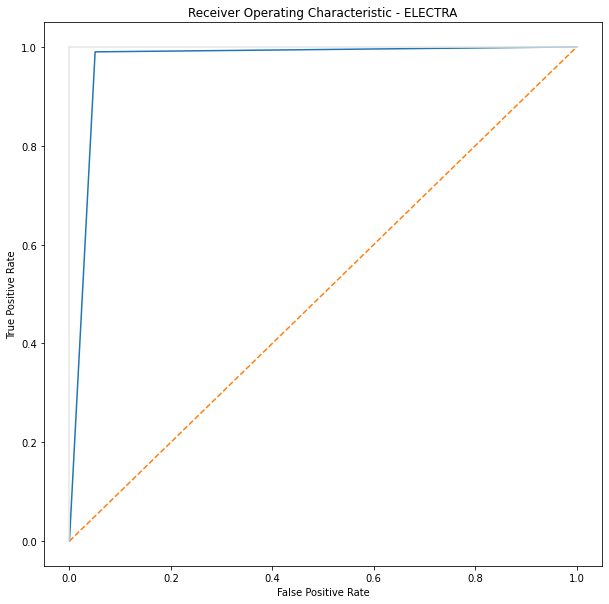

In [31]:
plt.subplots(figsize=(10,10))
plt.title('Receiver Operating Characteristic - ELECTRA')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c="0.9"), plt.plot([1, 1] , c="0.9")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


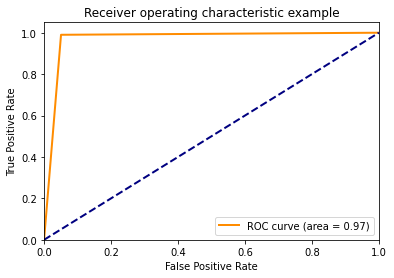

In [32]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [33]:
print(len(fpr))

3


In [34]:
print(tpr)

[0.   0.99 1.  ]
